In [1]:
import sys

sys.path.append('../sht')
from sht import DirectSHT

import numpy as np
from scipy.stats import mode
import jax.numpy as jnp
from jax import jit, vmap, device_put
import healpy as hp
import matplotlib.pyplot as plt
import utils

%load_ext autoreload
%autoreload 2

In [2]:
# We can very quickly calculate Ylm values. As an example, compute them up to lmax=Nl
Nl  = 500
Nx  = 1024

sht = DirectSHT(Nl,Nx)
x_samples = sht.x

In [3]:
def get_points(Nrandoms):
    # A function to randomly generate data points
    thetas = np.random.uniform(np.pi/8, np.pi/2., Nrandoms)
    phis = np.random.uniform(0, np.pi, Nrandoms)
    wts = np.random.uniform(1, 1.5, Nrandoms)
    
    x=np.cos(thetas)

    sorted_idx = np.argsort(x)
    x_data_sorted = x[sorted_idx]; w_i_sorted = wts[:][sorted_idx]; phi_data_sorted = phis[:][sorted_idx]
    return x_data_sorted, w_i_sorted, phi_data_sorted

In [4]:
Nrandoms = int(1e7)
x_data_sorted, w_i_sorted, phi_data_sorted = get_points(Nrandoms)
spline_idx = np.digitize(x_data_sorted, x_samples) - 1
t = x_data_sorted - x_samples[spline_idx]

# Put things in the GPU
x_data_sorted_jax = device_put(x_data_sorted)
spline_idx_jax = device_put(spline_idx)

Metal device set to: Apple M2 Max


2023-11-22 22:36:37.910157: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


In [23]:
def find_transitions(arr):
    '''
    Find the indices of transitions between different values in an array
    :param arr: 1D numpy array indicating what bin each element belongs to (must be sorted)
    :return: 1D numpy array of indices where the value in arr changes (includes 0)
    '''
    # Find the differences between consecutive elements
    differences = np.diff(arr)
    # Find the indices where differences are non-zero
    transition_indices = np.nonzero(differences)[0] + 1
    # Prepend a zero for convenience
    transition_indices = np.insert(transition_indices, 0, 0, axis=0)
    return transition_indices

def reshape_array(data, transitions, bin_num, bin_len):
    '''
    Reshape a 1D array into a 2D array to facilitate binning
    :param data: 1D numpy array of data to be binned
    :param transitions: 1D numpy array of indices where the value in data changes (includes 0)
    :param bin_num: int. Number of bins where there is data 
    :param bin_len: int. Maximum number of points in a bin
    :return: 2D numpy array of reshaped data, zero padded in bins with fewer points
    '''
    data_reshaped = np.zeros((bin_num, bin_len))
    for i in range(bin_num-1):
        fill_in = data[transitions[i]:transitions[i+1]]
        data_reshaped[i,:len(fill_in)] = fill_in
    return data_reshaped

# First, we find the number of different bins that are populated
occupied_bins = np.unique(spline_idx)
bin_num = len(occupied_bins)
# Then, we find the maximum number of points in a bin
bin_len = mode(spline_idx).count
# Find the indices of transitions between bins
transitions = find_transitions(spline_idx)
# Reshape the inputs into a 2D array for fast binning
reshaped_inputs = [device_put(reshape_array(w_i_sorted*input_,transitions,bin_num,bin_len))
                   for input_ in [(2*t+1)*(1-t)**2, t*(1-t)**2, t**2*(3-2*t), t**2*(t-1)]]
reshaped_phi_data = device_put(reshape_array(phi_data_sorted,transitions,bin_num,bin_len))
# Make a mask to discard spurious zeros
mask = reshaped_inputs[0]!=0
reshaped_inputs = [input_*mask for input_ in reshaped_inputs]
reshaped_phi_data *= mask

In [68]:
from functools import partial
@jit
def collapse(arr):
    '''
    Sum over the second axis of a 2D array -- i.e., the key binning operation!
    :param arr: 2D numpy array, where the 1st axis contains the different bins
                and the 2nd axis contains the data in each bin
    :return: 1D numpy array of the sums of the data in each bin
    '''
    return jnp.sum(arr, axis=1)

@jit
def get_vs(m, phi_data_sorted, reshaped_inputs):
    phi_dep_real,phi_dep_imag = [fn(m*phi_data_sorted) for fn in [jnp.cos, jnp.sin]]
    vs_real = [collapse(input_*phi_dep_real) for input_ in reshaped_inputs]
    vs_imag = [collapse(input_*phi_dep_imag) for input_ in reshaped_inputs]
    return [jnp.stack(vs, axis=-1) for vs in [vs_real, vs_imag]]

In [69]:
ms = np.arange(100)
vs_list = []
for i, m in enumerate(ms):
    vs_list.append([get_vs(m, reshaped_phi_data, reshaped_inputs)])

# Package it together with the calculation of the alms

First, we consider an approach where we step over m. This minimizes memory requirements, but it should be slower 

In [73]:
def get_alm_jax(Ylm, dYlm, vs):
    """
    The key function: get alm by summing over all interpolated weighted
    Y_lm's using JAX. Interpolation uses cubic Hermite splines
    :param Ylm: 1d numpy array of Ylm samples. Ideally, in device memory already
    :param dYlm: 1d numpy array of first derivatives of Ylm at sample points.\
                 Ideally, in device memory already
    :param vs: np array of size (Nsamples_theta,4) with the v_{i,j}(m) \
               (at a fixed m) used in the direct_SHT algorithm
    :param m: m value of the alm we want to calculate
    :return: a 1D numpy array with the alm value
    """
    return(jnp.sum(Ylm[:-1] * vs[:-1,0] + dYlm[:-1] * vs[:-1,1] +\
                   Ylm[ 1:] * vs[1:,2] + dYlm[ 1:] * vs[1:,3]))

get_all_alms_w_jax = vmap(jit(get_alm_jax),in_axes=(0,0,None))

In [58]:
Yv_jax  = device_put(sht.Yv[:,occupied_bins])
dYv_jax = device_put(sht.Yd[:,occupied_bins])
ell_ordering,m_ordering = utils.getlm(sht.Nell-1,len(sht.Yv[:, 0]))

In [77]:
alm_grid_real = np.zeros(len(sht.Yv[:, 0])); alm_grid_imag = np.zeros(len(sht.Yv[:, 0]))

for i, m in enumerate(ms):
    vs_real, vs_imag = get_vs(m, reshaped_phi_data, reshaped_inputs)
    indices = np.where(m_ordering==m)[0]
    alm_grid_real[indices] = get_all_alms_w_jax(Yv_jax[indices], dYv_jax[np.where(m_ordering==m)[0]], vs_real)
    alm_grid_imag[indices] = get_all_alms_w_jax(Yv_jax[indices], dYv_jax[np.where(m_ordering==m)[0]], vs_imag)

alm_grid = (np.array(alm_grid_real, dtype='complex128')
                            - 1j *np.array(alm_grid_imag, dtype='complex128'))

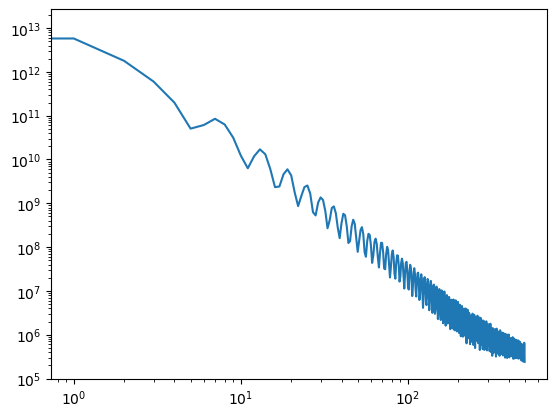

/var/folders/zf/xwwhf0ps6yx93zy9ttqm3mm80000gn/T/ipykernel_10652/1007985235.py:7: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  hp.mollview(hp.alm2map(alm_grid, 64, verbose=False))


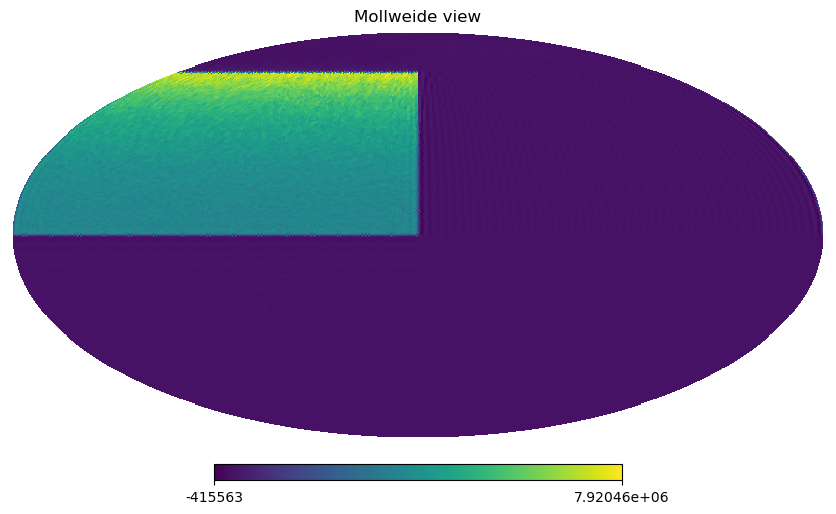

In [81]:
plt.loglog(hp.alm2cl(alm_grid))
plt.show()

hp.mollview(hp.alm2map(alm_grid, 64, verbose=False))